In [ ]:
%pip install transformers 
%pip install sklearn
%pip install datasets

In [2]:
import sys 

sys.path.append("/Users/max/Desktop/Dissertation/implementations/Disso-COLD/functions")

In [3]:
#from sklearn.datasets import fetch_20newsgroups #encountered issues SSLCertificationError with this 
from datasets import load_dataset, load_metric
import os
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding,get_scheduler
from torch.optim import AdamW

from spacy import tokenizer
from spacy.lang.en import English
import torch
from torch.utils.data import DataLoader
from utils import RoBERT_Model,ToBERT_Model
import json
import matplotlib.pyplot as plt

In [4]:
accuracy = load_metric('accuracy'); f1_score = load_metric('f1'); perplexity = load_metric('perplexity')

In [5]:
hyperpartisan_dataset = load_dataset("hyperpartisan_news_detection", "bypublisher") #Not stripped of headers and footers
hyperpartisan_dataset.keys()

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/600000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/600000 [00:00<?, ? examples/s]

Dataset hyperpartisan_news_detection downloaded and prepared to /root/.cache/huggingface/datasets/hyperpartisan_news_detection/bypublisher/1.0.0/7f4215b0474950ddf516e806400ab81d098b3da3b3a919a13cd1a4cf2c677012. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

dict_keys(['train', 'validation'])

In [6]:
#change to bypublisher because byarticle has no test set.
hyperpartisan_train = hyperpartisan_dataset['train']
hyperpartisan_valid = hyperpartisan_dataset['validation']

hyperpartisan_train = hyperpartisan_train.shuffle(seed = 32)
hyperpartisan_test = hyperpartisan_valid.shuffle(seed = 32)

With huggingface

In [7]:
max_input_length = 300 
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 2, max_length = max_input_length)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer) #to pad sequences

f1_score = load_metric("f1"); precision = load_metric("precision"); recall = load_metric("recall")

def tokenize(batch):
    return tokenizer(batch['text'], truncation=True, max_length=max_input_length)

def compute_metrics(eval_pred):
    predictions, label = eval_pred
    predictions = np.argmax(predictions, axis = 1)
    return {"f1" :f1_score.compute(predictions = predictions, references = label, average = 'weighted'),
            "precision" : precision.compute(predictions = predictions, references = label, average = 'weighted'),
            "recall": recall.compute(predictions = predictions, references = label, average = 'weighted')}

def hp_space(trial):
  return {"per_device_train_batch_size": trial.suggest_discrete_uniform("per_device_train_batch_size", 8,32,8)
        ,"learning_rate": trial.suggest_float("learning_rate", 0.0001,0.0005, log = True)
        ,"num_train_epochs": trial.suggest_int("num_train_epochs",1,10)
  }

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [8]:
hyperpartisan_train = hyperpartisan_train.select(range(10000)) #inconclusive because of nature of dataset
hyperpartisan_test = hyperpartisan_test.select(range(10000))

In [9]:
int_labels_train = {i: 1 if x == True else 0 for i,x in enumerate(hyperpartisan_train['hyperpartisan'])}
#int_labels_eval = {i: 1 if x == True else 0 for i,x in enumerate(hyperpartisan_eval['hyperpartisan'])}
int_labels_test = {i: 1 if x == True else 0 for i,x in enumerate(hyperpartisan_test['hyperpartisan'])}

In [10]:
hyperpartisan_train = hyperpartisan_train.map(tokenize)
hyperpartisan_test = hyperpartisan_test.map(tokenize)

  0%|          | 0/10000 [00:00<?, ?ex/s]

  0%|          | 0/10000 [00:00<?, ?ex/s]

In [11]:
hyperpartisan_train = hyperpartisan_train.add_column("labels", int_labels_train.values())

In [12]:
hyperpartisan_test = hyperpartisan_test.add_column("labels", int_labels_test.values())

(array([5024.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        4976.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

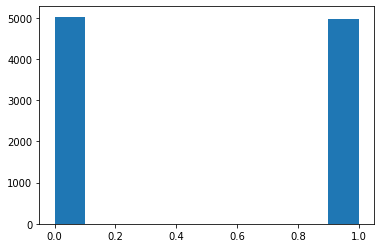

In [13]:
#Insight into the distribution of the dataset
plt.hist(hyperpartisan_train['labels'])

In [16]:
from sklearn.model_selection import KFold

In [17]:
fold = KFold(n_splits = 5)
this_set = fold.split(hyperpartisan_train['text'])

fold_train = []
fold_eval = []

for i,j in this_set:
  fold_train.append(hyperpartisan_train.select(i))
  fold_eval.append(hyperpartisan_train.select(j))

In [ ]:

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 2, max_length = max_input_length)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer) #to pad sequences

#default training arguments 
training_args = TrainingArguments(output_dir="./results", per_device_train_batch_size=16, 
                                  evaluation_strategy= "epoch", per_device_eval_batch_size=16, num_train_epochs=5,weight_decay=0.01)

#fine-tuning model
trainer = Trainer(model = model,
              args = training_args,
              train_dataset= fold_train[3],
              eval_dataset= fold_eval[3],
              tokenizer= tokenizer,
              data_collator=data_collator,
              compute_metrics= compute_metrics)

#searching for best hyperparameters
trainer.train()

In [ ]:
trainer.evaluate()

In [ ]:
results  = trainer.predict(hyperpartisan_test)

In [ ]:
set(results.label_ids)

{0, 1}

In [ ]:
results_that = list(np.argmax(results.predictions, axis = 1))
results_that 

EXPORTING RESULTS

In [ ]:
import pickle

In [ ]:
with open('hyperpartisan_no_chunk_orig_result_300.pkl', "wb") as out_1:
  pickle.dump(results.label_ids, out_1)

In [ ]:


with open("hyperpartisan_no_chunk_result_300.pkl", "wb") as outs:
  pickle.dump(results_that, outs)

In [ ]:
#display result 
#display confusion matrix

CHECKING PREDICTIONS - 300

In [ ]:
with open("hyperpartisan_no_chunk_result_300.pkl", "rb") as ins:
    results_300 = pickle.load(ins)

with open('hyperpartisan_no_chunk_orig_result_300.pkl', "rb") as ins_1:
    orig_300 = pickle.load(ins_1)

In [ ]:
correct = []; incorrect = []

for a,(b,c) in enumerate(zip(orig_300,results_300)):
    if b == c:
        correct.append(a)
    else:
        incorrect.append(a)

In [ ]:
incorrect

In [ ]:
incorrect_1 = {item: hyperpartisan_test['text'][item] for item in incorrect}
incorrect_1

In [ ]:
from utils import AssessData

{'Too Long': 9, 'Long': 112, 'BERT': 27, 'Short': 19}


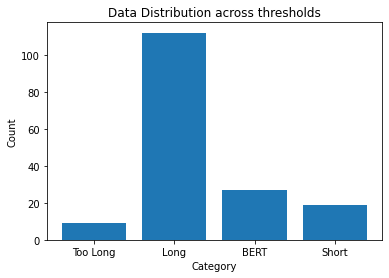

In [ ]:
temp = AssessData(incorrect_, dict)
temp._create_distribution()
temp._visualise()

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

{'f1': 0.9831738035264485}


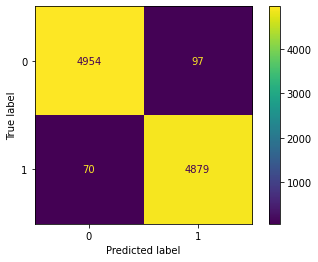

In [ ]:
ConfusionMatrixDisplay.from_predictions(results_300, hyperpartisan_test['labels'])
f1 = f1_score.compute(predictions= results_300, references = hyperpartisan_test["labels"])
print(f1)

CHECKING PREDICTIONS - 512

In [ ]:
max_input_length = 512

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 2, max_length = max_input_length)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer) #to pad sequences

#default training arguments 
training_args = TrainingArguments(output_dir="./results", per_device_train_batch_size=16, 
                                  evaluation_strategy= "epoch", per_device_eval_batch_size=16, num_train_epochs=5,weight_decay=0.01)

#fine-tuning model
trainer = Trainer(model = model,
              args = training_args,
              train_dataset= fold_train[3],
              eval_dataset= fold_eval[3],
              tokenizer= tokenizer,
              data_collator=data_collator,
              compute_metrics= compute_metrics)

#searching for best hyperparameters
trainer.train()

In [19]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: url, published_at, title, hyperpartisan, text, bias. If url, published_at, title, hyperpartisan, text, bias are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 16


Trainer is attempting to log a value of "{'f1': 0.9099990999964}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.910043702141405}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.91}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.6063188910484314,
 'eval_f1': {'f1': 0.9099990999964},
 'eval_precision': {'precision': 0.910043702141405},
 'eval_recall': {'recall': 0.91},
 'eval_runtime': 21.0765,
 'eval_samples_per_second': 94.892,
 'eval_steps_per_second': 5.931,
 'epoch': 5.0}

In [20]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: url, published_at, title, hyperpartisan, text, bias. If url, published_at, title, hyperpartisan, text, bias are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 16


Trainer is attempting to log a value of "{'f1': 0.9099990999964}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.910043702141405}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.91}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.6063188910484314,
 'eval_f1': {'f1': 0.9099990999964},
 'eval_precision': {'precision': 0.910043702141405},
 'eval_recall': {'recall': 0.91},
 'eval_runtime': 21.1283,
 'eval_samples_per_second': 94.66,
 'eval_steps_per_second': 5.916,
 'epoch': 5.0}

In [23]:
result = trainer.predict(hyperpartisan_test)

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: url, published_at, title, hyperpartisan, text, bias. If url, published_at, title, hyperpartisan, text, bias are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 10000
  Batch size = 16


In [25]:
results_512 = np.argmax(result.predictions, axis = 1)
results_512

array([1, 1, 1, ..., 1, 1, 1])

In [33]:
import pickle

with open("hyperpartisan_no_chunk_result_512.pkl", "wb") as out:
  pickle.dump(results_512, out)

{'f1': 0.9810336176618163}


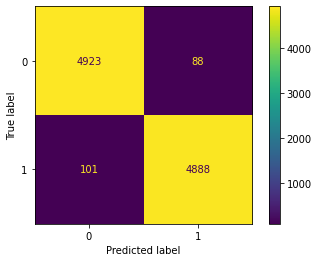

In [37]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(results_512, hyperpartisan_test['labels'])
f1 = f1_score.compute(predictions= results_512, references = hyperpartisan_test["labels"])
print(f1)

In [41]:
correct = []; incorrect = []; incorrect_labels = []
orig_labels = hyperpartisan_test['labels']

for a,(b,c) in enumerate(zip(orig_labels, results_512)):
    if b == c:
        correct.append(a)
    else:
        incorrect.append(a)
        incorrect_labels.append((b,c,))

len(incorrect)

189

In [43]:
set(orig_labels)

{0, 1}

In [39]:
incorrect_2 = {item: hyperpartisan_test['text'][item] for item in incorrect}
incorrect_2

{2014: '<p>&#8216;Traitors!&#8221; screamed the headline of the New York Daily News. &#8220;Beneath the dignity of the institution I revere,&#8221; huffed Vice President Joe Biden. &#8220;Dangerous and irresponsible,&#8221; opined the Washington Post&#8217;s David Ignatius. President Obama offered that it was &#8220;ironic&#8221; that the senators were on the same side as supposed &#8220;hardliners&#8221; in Iran.</p> \n\n<p>The occasion for all of this snorting and pawing of earth was the letter signed by 47 Senate Republicans explaining to Iran&#8217;s leadership that an &#8220;executive agreement&#8221; is only valid for the term of the executive.</p> \n\n<p>President Obama mentioned irony. Here&#8217;s the one he doesn&#8217;t see: He is hardly in a position to rebuke another branch for exceeding its constitutional authority.</p> \n\n<p>First, a word about the executive branch. Though many presidents have claimed (and often been granted) primacy in foreign affairs, this is traditio

In [ ]:
with open("hyperpartisan_no_chunk_result_512.pkl", "rb") as ins:
    results_512 = pickle.load(ins)

with open('orig_result_512.pkl', "rb") as ins_1:
    orig_512 = pickle.load(ins_1)

In [ ]:
correct = []; incorrect = []

for a,(b,c) in enumerate(zip(orig_512,results_512)):
    if b == c:
        correct.append(a)
    else:
        incorrect.append(a)

{'f1': 0.9719350073855243}


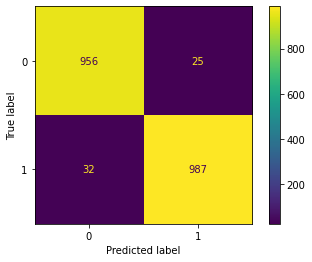

In [ ]:
ConfusionMatrixDisplay.from_predictions(results_512, hyperpartisan_test.select(range(2000))['labels'])
f1 = f1_score.compute(predictions= results_512, references = hyperpartisan_test.select(range(2000))["labels"])
print(f1)

In [ ]:
incorrect_2 = {item: hyperpartisan_test['text'][item] for item in incorrect}
incorrect_2

{'Too Long': 0, 'Long': 41, 'BERT': 8, 'Short': 8}


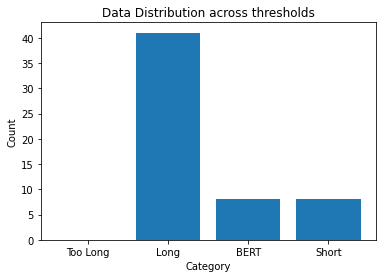

In [ ]:
temp_2 = AssessData(incorrect_2, dict)
temp_2._create_distribution()
temp_2._visualise()